In [1]:
import os
import sys
sys.path.append('../train/')

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from util import array2mat

/home/liminghong/miniconda3/envs/see/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_set = np.load('/data/liminghong/sclab/sclab/train_dataset.npy', allow_pickle=True)
eval_set = np.load('/data/liminghong/sclab/sclab/eval_dataset.npy', allow_pickle=True)
data_set = np.append(train_set, eval_set)


def show_by_cell_type(cell_type, gene_name):
    _hics, num = None, 0
    for _data in data_set:
        if _data['cell_type'] != cell_type:
            continue
        num += 1
        _hic = _data['scHiC'][gene_name].astype(float)
        _hic[_hic<0] = 0
        if _hics is None:
            _hics = _hic.copy()
        else:
            _hics += _hic
    return _hics/num


def heatmap_triangle(
    axes, mat, matBalance=False,
    width=6, height=3, cmap=mpl.cm.Greys, showXticks=True, title=None, ymax=None, logData=False
):
    if logData == True:
        mat = np.log2(mat)

    N = mat.shape[1]

    # Transformation matrix for rotating the heatmap.
    A = np.array([(y, x) for x in range(N, -1, -1) for y in range(N + 1)])
    t = np.array([[1,0.5], [-1,0.5]])
    A = np.dot(A, t)

    C = np.triu(mat)

    # This MUST be before the call to pl.pcolormesh() to align properly.
    #axes.set_xticks([])
    axes.set_yticks([])

    # Plot the correlation heatmap triangle.
    X = A[:, 1].reshape(N + 1, N + 1)
    Y = A[:, 0].reshape(N + 1, N + 1)

    #caxes = pl.pcolormesh(X, Y, np.fliplr(C), axes=axes, cmap=cmap, norm=norm)

    #norm=MidpointNormalize(midpoint=0,vmin=-1, vmax=1)
    caxes = axes.pcolormesh(X, Y, np.flipud(C), axes=axes, cmap=cmap, edgecolor='none', snap=True, linewidth=.001)
    #caxes = axes.matshow(np.flipud(C), cmap=cmap, norm=norm)

    # Remove the ticks and reset the x limit.

    axes.set_ylim(bottom=0)
    axes.set_xlim(left=0)
    if ymax != None: 
        axes.set_ylim(top=ymax)
    axes.set_title(title)
    
    #set_heatmap_ticks(axes)
    
    axes.axis("off")
#     colorbar_triangle(axes, caxes, ymax)


def pre_track(predict_array, title):
    fig = plt.figure(figsize=(20, 9), facecolor='white')
    plt.subplots_adjust(left=0.2, bottom=0.1, right=0.8, top=0.8, hspace=0.3, wspace=0.15)

    gs = fig.add_gridspec(9, 1)
    ax0 = fig.add_subplot(gs[0:8, 0], facecolor='white')

    _test = array2mat(predict_array)
    # _test += abs(_test.min())
    row, col = np.diag_indices_from(_test)
    _diag = _test[row,col].copy()
    
    _test[row,col] = 0
    heatmap_triangle(ax0, _test, width=6, height=2.7, logData=False)
    
    plt.savefig(title, format='pdf', bbox_inches='tight')
    plt.show()

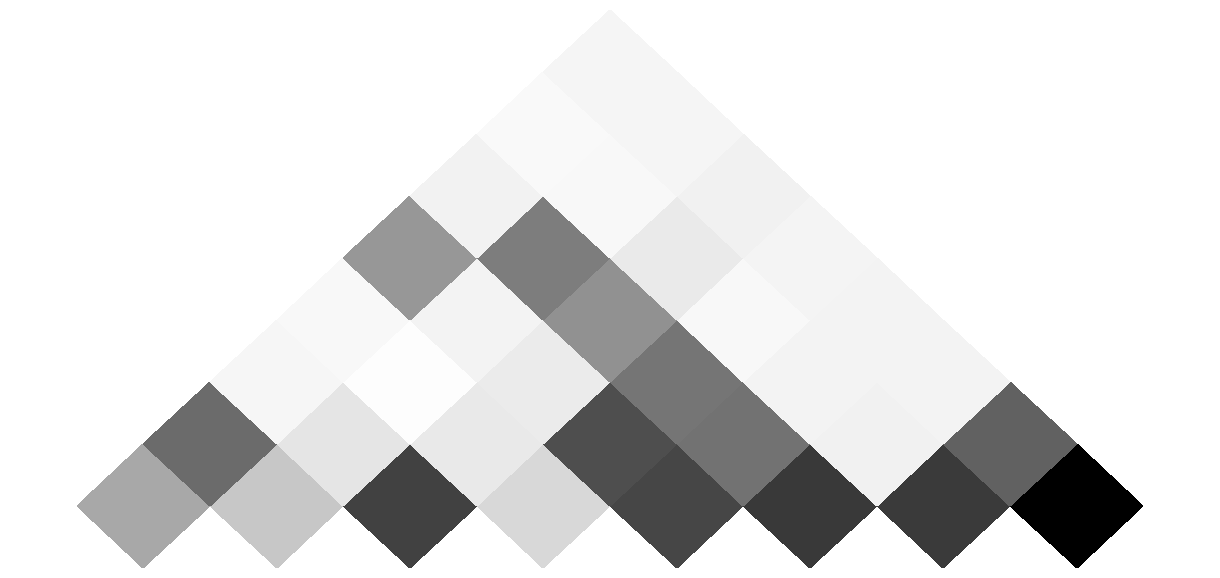

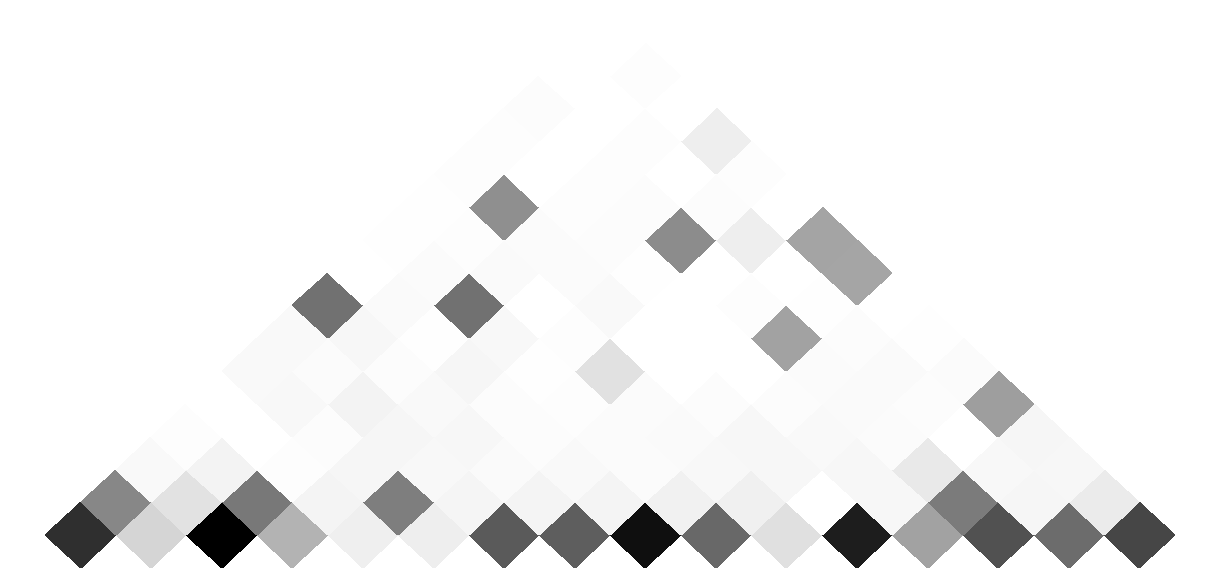

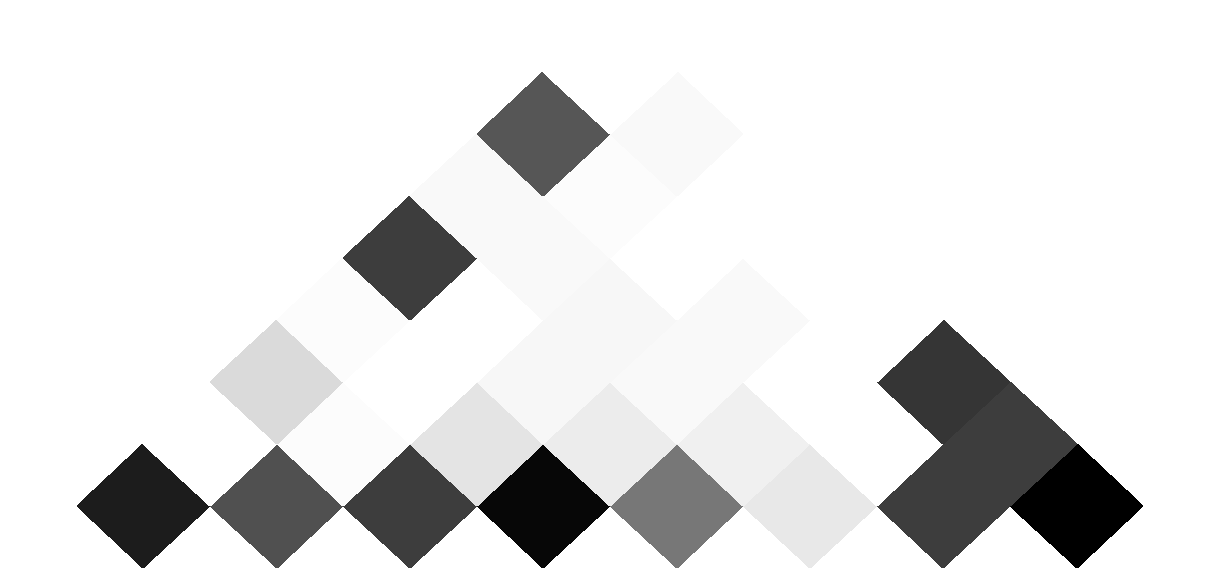

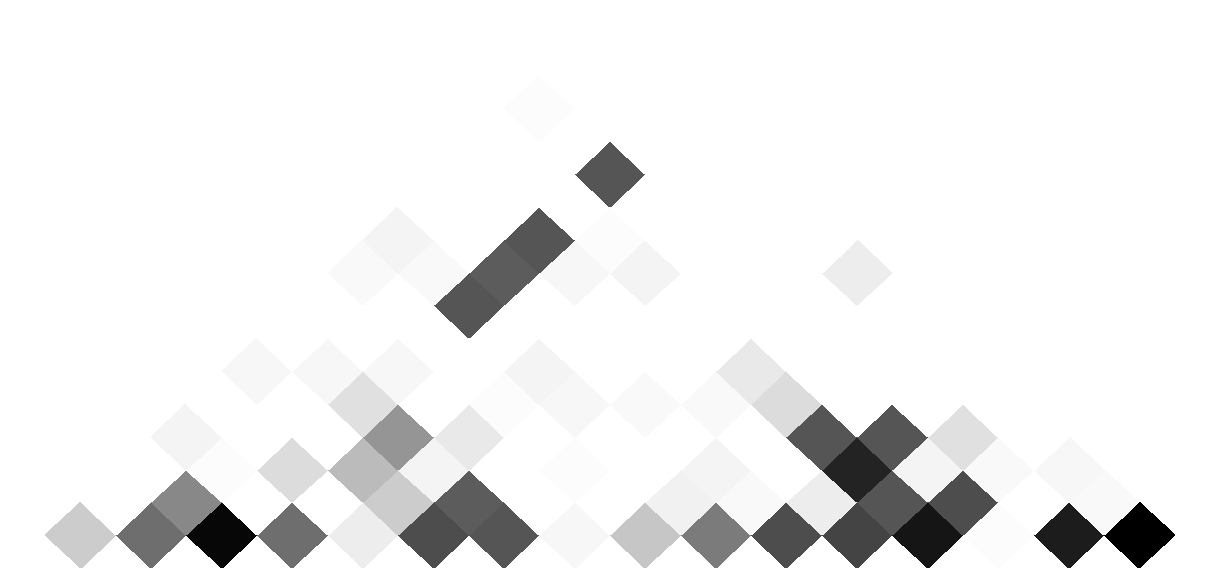

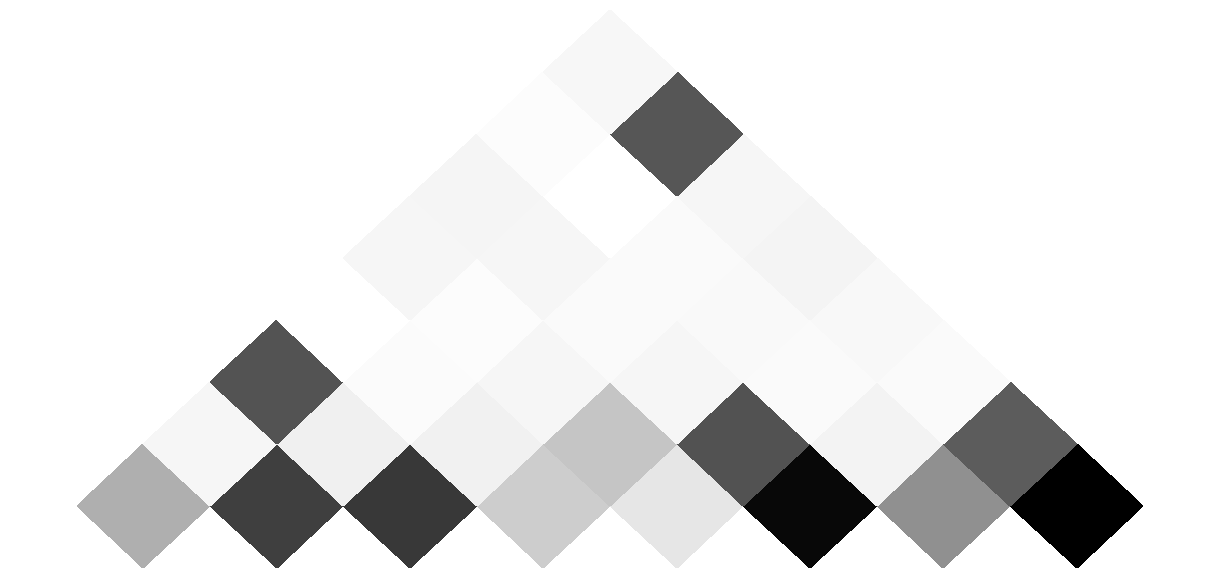

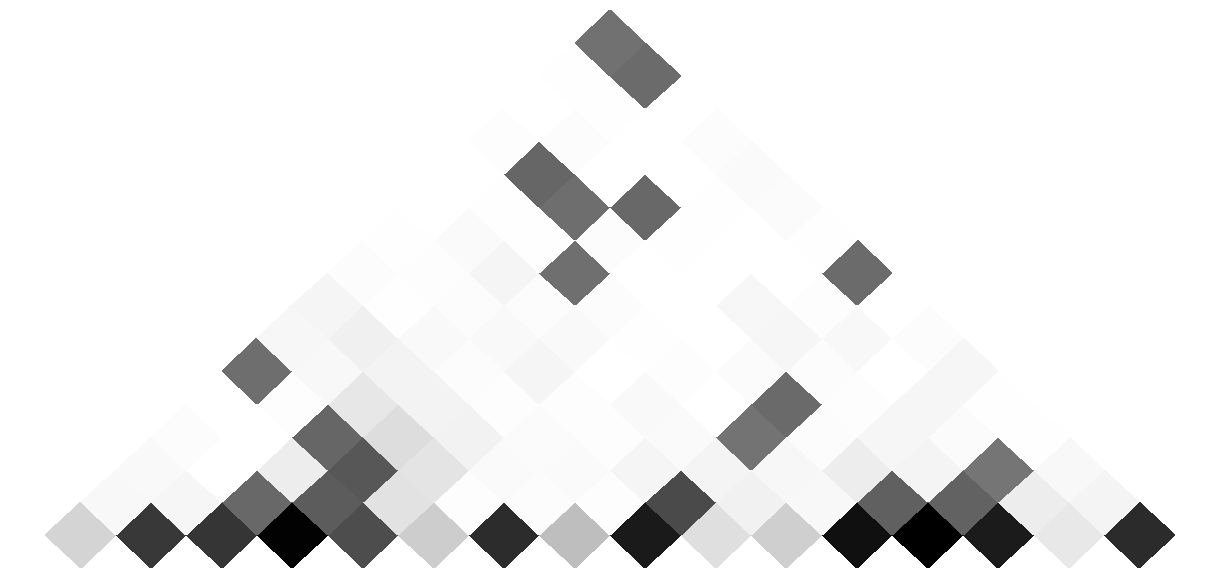

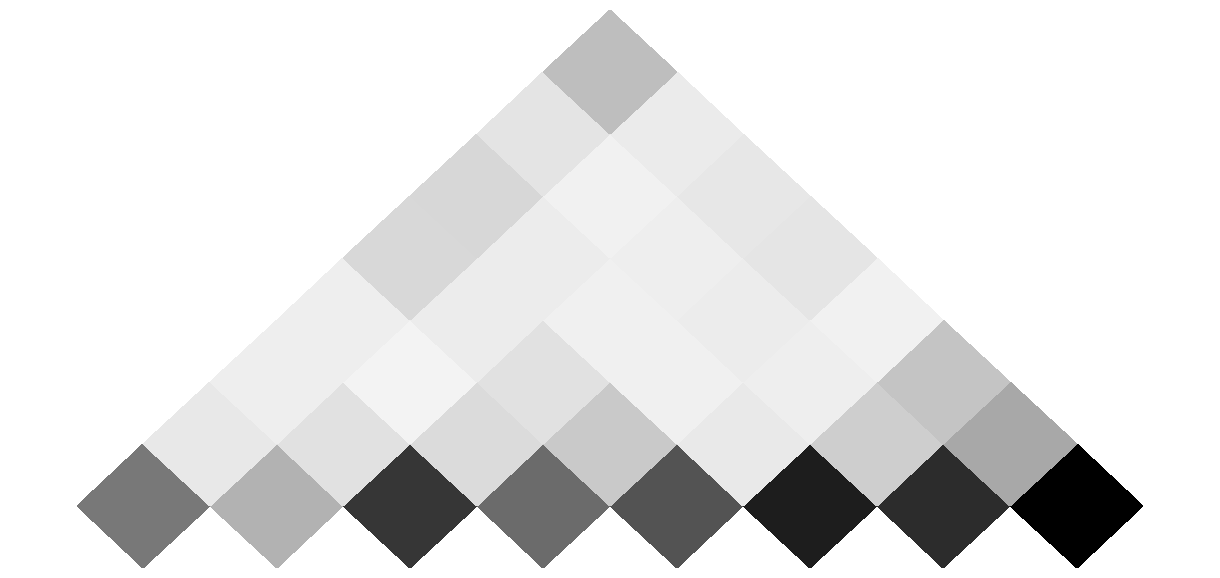

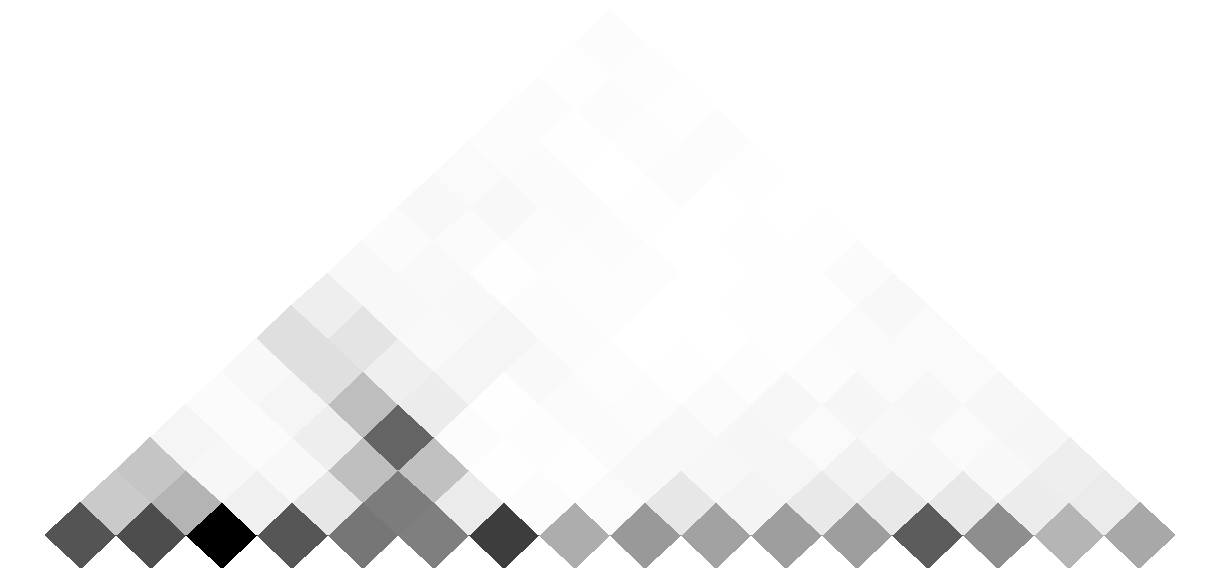

In [3]:
for cell_type in ["Astro", "Endo", "OPC", "ODC"]:
    for gene_name in ["SLC1A3", "MBP"]:
        pre_track(show_by_cell_type(cell_type, gene_name), "heatmap_{}_{}.pdf".format(cell_type, gene_name))